Epoch 1 - Train Loss: 1.1856 - Test Loss: 1.0100
Epoch 10 - Train Loss: 0.9830 - Test Loss: 0.9678
Epoch 20 - Train Loss: 0.8832 - Test Loss: 1.0000
Epoch 30 - Train Loss: 0.8432 - Test Loss: 1.0469
Epoch 40 - Train Loss: 0.8074 - Test Loss: 1.0011
Epoch 50 - Train Loss: 0.7736 - Test Loss: 0.9639
Epoch 60 - Train Loss: 0.7389 - Test Loss: 0.9373
Epoch 70 - Train Loss: 0.7057 - Test Loss: 0.9288
Epoch 80 - Train Loss: 0.6725 - Test Loss: 0.9153
Epoch 90 - Train Loss: 0.6419 - Test Loss: 0.9003
Epoch 100 - Train Loss: 0.6102 - Test Loss: 0.8766
Epoch 110 - Train Loss: 0.5795 - Test Loss: 0.8741
Epoch 120 - Train Loss: 0.5503 - Test Loss: 0.8812
Epoch 130 - Train Loss: 0.5229 - Test Loss: 0.8816
Epoch 140 - Train Loss: 0.4988 - Test Loss: 0.9033
Epoch 150 - Train Loss: 0.4744 - Test Loss: 0.8542
Epoch 160 - Train Loss: 0.4516 - Test Loss: 0.8726
Epoch 170 - Train Loss: 0.4309 - Test Loss: 0.9033
Epoch 180 - Train Loss: 0.4124 - Test Loss: 0.9355
Epoch 190 - Train Loss: 0.3961 - Test Loss

/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


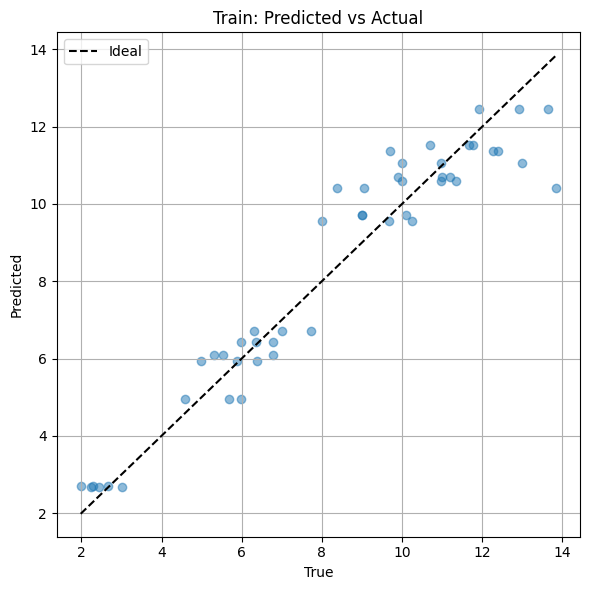

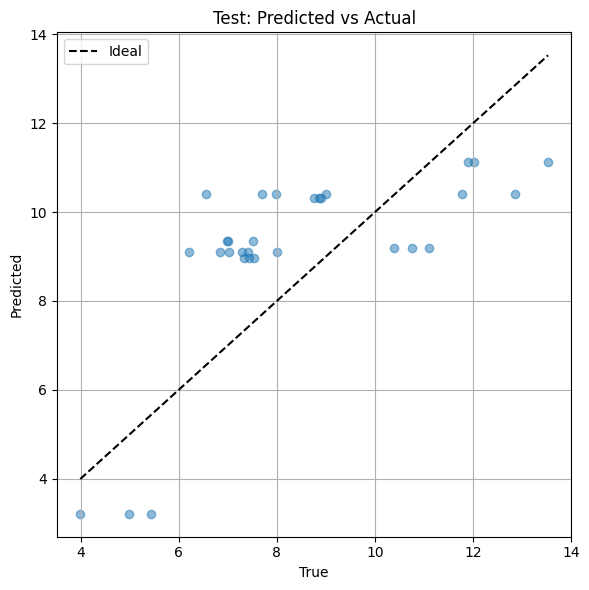

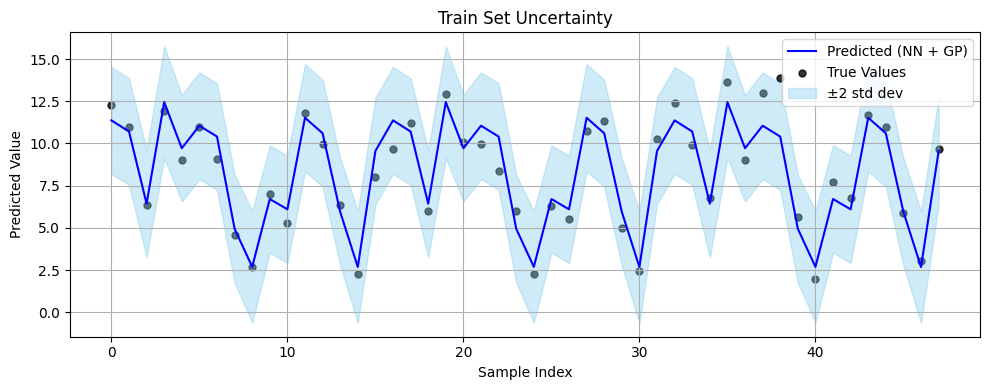

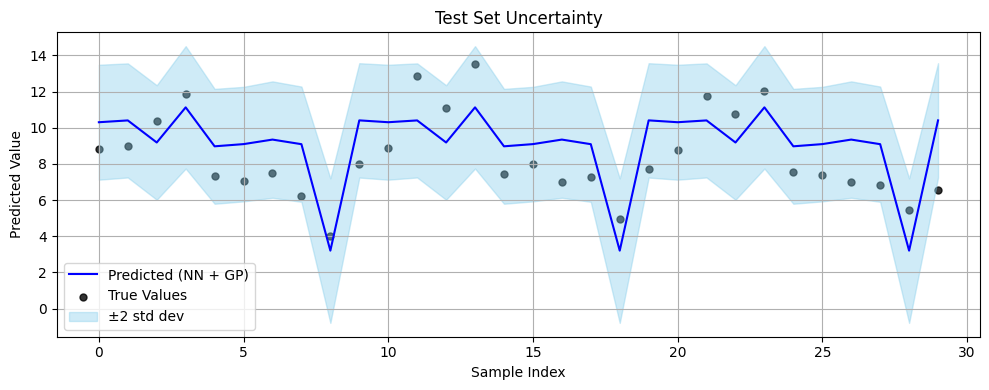

Lengthscale: tensor([[0.8011]], grad_fn=<SoftplusBackward0>)
Outputscale: tensor(1.3677, grad_fn=<SoftplusBackward0>)


In [77]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random
import copy

# === Set random seed ===
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# === Early stopping ===
class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.best_state = None

    def __call__(self, loss, model):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# === Load and preprocess data ===
df = pd.read_excel("data.xlsx")
relevant_columns = ['a', 'b', 'c', 'd']
df_train, df_test = train_test_split(df, test_size=0.35, random_state=42)

train_long = pd.melt(df_train, id_vars=relevant_columns, value_vars=[1, 2, 3],
                     var_name='trial', value_name='result')
test_long = pd.melt(df_test, id_vars=relevant_columns, value_vars=[1, 2, 3],
                    var_name='trial', value_name='result')

X_train_raw = train_long[relevant_columns].values
y_train_raw = train_long['result'].values
X_test_raw = test_long[relevant_columns].values
y_test_raw = test_long['result'].values

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_raw)
X_test_poly = poly.transform(X_test_raw)

# Scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1)).ravel()

# Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# === Neural network feature extractor ===
class FeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, embed_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        return self.net(x)

# === GP model with NN features ===
class DKLGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, feature_extractor):
        super().__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.mean_module = gpytorch.means.ConstantMean()


        rbf_kernel = gpytorch.kernels.RBFKernel()
        linear_kernel = gpytorch.kernels.LinearKernel()
        periodic_kernel = gpytorch.kernels.PeriodicKernel()
        
        # Combine kernels additively
        combined_kernel = rbf_kernel + linear_kernel + periodic_kernel
        
        self.covar_module = gpytorch.kernels.ScaleKernel(combined_kernel)

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() )

    def forward(self, x):
        projected_x = self.feature_extractor(x)
        mean = self.mean_module(projected_x)
        covar = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

# === Training loop ===
def train_dkl_model(seed):
    set_seed(seed)
    feature_extractor = FeatureExtractor(X_train_scaled.shape[1])
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = DKLGPModel(X_train_tensor, y_train_tensor, likelihood, feature_extractor)

    model.train()
    likelihood.train()

    optimizer = optim.Adam([
        {'params': model.feature_extractor.parameters()},
        {'params': model.covar_module.parameters()},
        {'params': model.mean_module.parameters()},
        {'params': model.likelihood.parameters()},
    ], lr=0.01)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    early_stop = EarlyStopping(patience=100)

    for epoch in range(1, 1000 + 1):
        # Training step
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = -mll(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Evaluate test loss for early stopping
        model.eval()
        likelihood.eval()
        with torch.no_grad():
            test_output = model(X_test_tensor)
            test_loss = -mll(test_output, y_test_tensor).item()
        model.train()
        likelihood.train()

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch} - Train Loss: {loss.item():.4f} - Test Loss: {test_loss:.4f}")

        early_stop(test_loss, model)
        if early_stop.early_stop:
            print(f"Early stopping at epoch {epoch} (Test Loss: {test_loss:.4f})")
            break

    model.load_state_dict(early_stop.best_state)
    model.eval()
    likelihood.eval()

    return model, likelihood

# === Train model ===
model, likelihood = train_dkl_model(seed=42)

# === Predictions (with uncertainty) ===
def predict(model, likelihood, X_tensor):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(X_tensor))
        mean = pred.mean.numpy()
        std = pred.stddev.numpy()
    return mean, std

# === Train predictions ===
mean_train_scaled, std_train_scaled = predict(model, likelihood, X_train_tensor)
y_train_pred = scaler_y.inverse_transform(mean_train_scaled.reshape(-1, 1)).ravel()
y_train_std = std_train_scaled * scaler_y.scale_[0]
y_train_true = y_train_raw

# === Test predictions ===
mean_test_scaled, std_test_scaled = predict(model, likelihood, X_test_tensor)
y_test_pred = scaler_y.inverse_transform(mean_test_scaled.reshape(-1, 1)).ravel()
y_test_std = std_test_scaled * scaler_y.scale_[0]
y_test_true = y_test_raw

# === Evaluation
def evaluate(y_true, y_pred, name=""):
    print(f"\n📊 {name} Set:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"R²:  {r2_score(y_true, y_pred):.4f}")

evaluate(y_train_true, y_train_pred, "Train")
evaluate(y_test_true, y_test_pred, "Test")

# === Plot: Predicted vs Actual
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()], 'k--', label="Ideal")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_predictions(y_train_true, y_train_pred, "Train: Predicted vs Actual")
plot_predictions(y_test_true, y_test_pred, "Test: Predicted vs Actual")

# === Plot: Uncertainty bands
def plot_uncertainty(y_pred, y_std, y_true, title):
    plt.figure(figsize=(10, 4))
    
    # Plot predicted mean
    plt.plot(y_pred, label='Predicted (NN + GP)', color='blue')
    
    # Plot true values
    plt.scatter(np.arange(len(y_true)), y_true, label='True Values', color='black', s=25, alpha=0.8)

    # Plot uncertainty band
    plt.fill_between(np.arange(len(y_pred)),
                     y_pred - 2 * y_std,
                     y_pred + 2 * y_std,
                     alpha=0.4, color='skyblue', label='±2 std dev')
    
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Predicted Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_uncertainty(y_train_pred, y_train_std,y_train_true, "Train Set Uncertainty")
plot_uncertainty(y_test_pred, y_test_std,y_test_true, "Test Set Uncertainty")
print("Lengthscale:", model.covar_module.base_kernel.lengthscale)
print("Outputscale:", model.covar_module.outputscale)


In [73]:
y_train_std.mean(),y_test_std.mean(),X_train_scaled

(np.float64(1.8738645997015864),
 np.float64(1.9246572919155662),
 array([[-4.25145461e-01,  3.62856519e-01, -6.02464076e-01,
         -8.70388280e-01, -4.50431056e-01, -9.42268155e-02,
         -7.05202504e-01, -9.46936410e-01,  3.38267055e-01,
         -4.52578915e-01, -6.67004270e-01, -8.10381735e-01,
         -9.44984470e-01, -7.70766557e-01],
        [-4.25145461e-01, -6.92726081e-01,  7.74596669e-01,
          5.22232968e-01, -4.50431056e-01, -7.50113773e-01,
          5.21977684e-01,  2.39437428e-01, -7.18696057e-01,
          4.52578915e-01,  1.62626483e-01,  9.09261204e-01,
          9.55784292e-01,  4.09354487e-01],
        [ 6.21366443e-01,  3.62856519e-01,  7.74596669e-01,
          5.22232968e-01,  5.89525206e-01,  7.07412799e-01,
          9.99214424e-01,  7.83192104e-01,  3.38267055e-01,
          8.74985903e-01,  6.60404934e-01,  9.09261204e-01,
          9.55784292e-01,  4.09354487e-01],
        [ 6.21366443e-01,  3.62856519e-01, -6.02464076e-01,
         -8.70388280e-

Epoch 0 - NLL: 56.4170
Epoch 50 - NLL: 40.3098
Epoch 100 - NLL: 39.8619
Epoch 150 - NLL: 39.8595
Epoch 200 - NLL: 39.8595
Epoch 250 - NLL: 39.8595
Epoch 300 - NLL: 39.8595
Epoch 350 - NLL: 39.8595
Epoch 400 - NLL: 39.8595
Epoch 450 - NLL: 39.8595
Epoch 500 - NLL: 39.8595
Epoch 550 - NLL: 39.8595
Epoch 600 - NLL: 39.8595
Epoch 650 - NLL: 39.8595
Epoch 700 - NLL: 39.8595
Epoch 750 - NLL: 39.8595
Epoch 800 - NLL: 39.8595
Epoch 850 - NLL: 39.8595
Epoch 900 - NLL: 39.8595
Epoch 950 - NLL: 39.8595
Epoch 1000 - NLL: 39.8595
Epoch 1050 - NLL: 39.8595
Epoch 1100 - NLL: 39.8595
Epoch 1150 - NLL: 39.8595
Epoch 1200 - NLL: 39.8595
Epoch 1250 - NLL: 39.8595
Epoch 1300 - NLL: 39.8595
Epoch 1350 - NLL: 39.8595
Epoch 1400 - NLL: 39.8595
Epoch 1450 - NLL: 39.8595
Epoch 1500 - NLL: 39.8595
Epoch 1550 - NLL: 39.8595
Epoch 1600 - NLL: 39.8595
Epoch 1650 - NLL: 39.8595
Epoch 1700 - NLL: 39.8595
Epoch 1750 - NLL: 39.8595
Epoch 1800 - NLL: 39.8595
Epoch 1850 - NLL: 39.8595
Epoch 1900 - NLL: 39.8595
Epoch 195

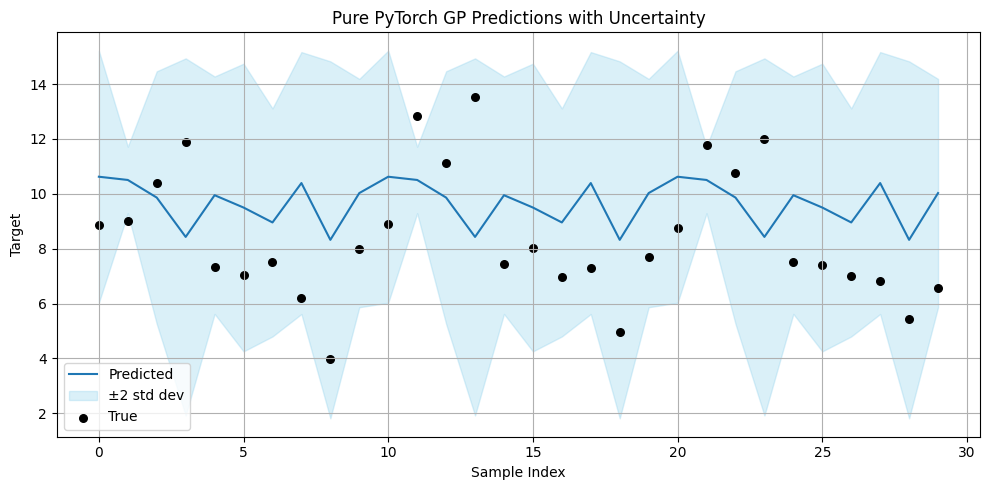


📌 Learned Hyperparameters:
Lengthscale: 1.0484
Variance:    0.9642
Noise:       0.113310


In [83]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random

# === Set random seed ===
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# === Load and preprocess data ===
df = pd.read_excel("data.xlsx")
relevant_columns = ['a', 'b', 'c', 'd']
df_train, df_test = train_test_split(df, test_size=0.35, random_state=42)

train_long = pd.melt(df_train, id_vars=relevant_columns, value_vars=[1, 2, 3],
                     var_name='trial', value_name='result')
test_long = pd.melt(df_test, id_vars=relevant_columns, value_vars=[1, 2, 3],
                    var_name='trial', value_name='result')

X_train_raw = train_long[relevant_columns].values
y_train_raw = train_long['result'].values
X_test_raw = test_long[relevant_columns].values
y_test_raw = test_long['result'].values

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1)).ravel()

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# === Pure PyTorch GP ===
class LearnableGP(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_lengthscale = nn.Parameter(torch.tensor(0.0))
        self.log_variance = nn.Parameter(torch.tensor(2.0))
        self.log_noise = nn.Parameter(torch.tensor(-3.0))

    def rbf_kernel(self, x1, x2):
        lengthscale = torch.exp(self.log_lengthscale)
        variance = torch.exp(self.log_variance)
        dists = torch.cdist(x1 / lengthscale, x2 / lengthscale, p=2).pow(2)
        return variance * torch.exp(-0.5 * dists)

    def forward(self, X_train, y_train):
        K = self.rbf_kernel(X_train, X_train)
        noise = torch.exp(self.log_noise)
        K_y = K + noise * torch.eye(len(X_train))
        L = torch.linalg.cholesky(K_y)
        alpha = torch.cholesky_solve(y_train, L)
        return L, alpha

    def predict(self, X_train, y_train, X_test):
        L, alpha = self.forward(X_train, y_train)
        K_star = self.rbf_kernel(X_test, X_train)
        mean = K_star @ alpha
        v = torch.cholesky_solve(K_star.T, L)
        K_ss = self.rbf_kernel(X_test, X_test)
        cov = K_ss - K_star @ v
        std = torch.sqrt(torch.diag(cov).clamp(min=1e-6)).reshape(-1, 1)
        return mean, std

# === Train ===
model = LearnableGP()
optimizer = optim.Adam(model.parameters(), lr=0.05)

for epoch in range(3000):
    model.train()
    optimizer.zero_grad()
    L, alpha = model(X_train_tensor, y_train_tensor)
    nll = 0.5 * y_train_tensor.T @ alpha + torch.log(torch.diag(L)).sum() + \
          0.5 * len(X_train_tensor) * torch.log(torch.tensor(2 * np.pi))
    nll.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch} - NLL: {nll.item():.4f}")

# === Predict ===
model.eval()
with torch.no_grad():
    mean_pred, std_pred = model.predict(X_train_tensor, y_train_tensor, X_test_tensor)

y_pred = scaler_y.inverse_transform(mean_pred.numpy().reshape(-1, 1)).ravel()
y_std = std_pred.numpy().ravel() * scaler_y.scale_[0]
y_true = y_test_raw

# === Evaluation ===
print("\n📊 Test Set Metrics:")
print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
print(f"R²:  {r2_score(y_true, y_pred):.4f}")

# === Plot with Uncertainty ===
plt.figure(figsize=(10, 5))
plt.plot(y_pred, label="Predicted")
plt.fill_between(np.arange(len(y_pred)),
                 y_pred - 2 * y_std,
                 y_pred + 2 * y_std,
                 alpha=0.3, label="±2 std dev", color="skyblue")
plt.scatter(np.arange(len(y_true)), y_true, label="True", color='black', s=30)
plt.title("Pure PyTorch GP Predictions with Uncertainty")
plt.xlabel("Sample Index")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print Learned Parameters ===
print("\n📌 Learned Hyperparameters:")
print(f"Lengthscale: {torch.exp(model.log_lengthscale).item():.4f}")
print(f"Variance:    {torch.exp(model.log_variance).item():.4f}")
print(f"Noise:       {torch.exp(model.log_noise).item():.6f}")
